<a href="https://colab.research.google.com/github/ethan-yoo/2022_aiffel_exp/blob/main/E06_killingverse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color=slateblue>E06. 인공지능 작사가 만들기 (feat. Adele, Eminem)</font>**
- 가사 데이터를 학습해서 작사를 할 수 있는 AI를 만들어봅시다!

---

## **01. 데이터 불러오기**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [107]:
import glob
import os
import re

txt_file_path = '/content/drive/MyDrive/AIFFEL/E06/lyrics/*'

# file_path의 파일명 리스트로 저장
txt_list = sorted(glob.glob(txt_file_path))

# 텍스트 데이터 담을 객체 생성
raw_corpus = []

# txt 파일 읽어와서 담기
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))

print(txt_list[:5])

데이터 크기: 187088
['/content/drive/MyDrive/AIFFEL/E06/lyrics/Kanye_West.txt', '/content/drive/MyDrive/AIFFEL/E06/lyrics/Lil_Wayne.txt', '/content/drive/MyDrive/AIFFEL/E06/lyrics/adele.txt', '/content/drive/MyDrive/AIFFEL/E06/lyrics/al-green.txt', '/content/drive/MyDrive/AIFFEL/E06/lyrics/alicia-keys.txt']


🥕 잘 불러와졌습니다. 총 187,088 줄의 데이터군요.

## **02. 데이터 정제하기 (토큰화하기)**

- 예시로 파일 하나를 살펴보겠습니다.

In [108]:
sample_path = txt_list[3]
with open(sample_path, "r") as f:
    f_sample = f.read().splitlines()

# 20줄만 출력
f_sample[0:20]

["Let's stay together I, I'm I'm so in love with you",
 'Whatever you want to do',
 'Is all right with me',
 'Cause you make me feel so brand new',
 "And I want to spend my life with you Let me say that since, baby, since we've been together",
 'Loving you forever',
 'Is what I need',
 'Let me, be the one you come running to',
 "I'll never be untrue Oh baby",
 "Let's, let's stay together (gether)",
 "Lovin' you whether, whether",
 'Times are good or bad, happy or sad',
 'Oh, oh, oh, oh, yeah',
 'Whether times are good or bad, happy or sad Why, why some people break up',
 'Then turn around and make up',
 "I just can't see",
 "You'd never do that to me (would you, baby)",
 'Staying around you is all I see',
 "(Here's what I want us do) Let's, we oughta stay together (gether)",
 'Loving you whether, whether']

🥕 흠, 각 문장은 작은 따옴표로 감싸여 있군요.

중간에 괄호로 감싸인 부분이 있는데, 제거할지 말지는 조금 더 생각해 봐야 할 것 같습니다.

다른 파일들도 마찬가지일까요? 하나 더 확인해봅시다.

In [109]:
sample_path = txt_list[21]
with open(sample_path, "r") as f:
    f_sample2 = f.read().splitlines()

# 20줄만 출력
f_sample2[0:20]

['[Hook]',
 "I've been down so long, it look like up to me",
 'They look up to me',
 "I got fake people showin' fake love to me",
 'Straight up to my face, straight up to my face',
 "I've been down so long, it look like up to me",
 'They look up to me',
 "I got fake people showin' fake love to me",
 'Straight up to my face, straight up to my face [Verse 1]',
 "Somethin' ain't right when we talkin'",
 "Somethin' ain't right when we talkin'",
 "Look like you hidin' your problems",
 'Really you never was solid',
 'No, you can\'t "son" me',
 "You won't never get to run me",
 'Just when shit look out of reach',
 'I reach back like one, three',
 'Like one, three, yeah [Pre-Hook]',
 "That's when they smile in my face",
 'Whole time they wanna take my place']

🥕 이번에는 대괄호가 등장했습니다.

내용을 보니 벌스와 훅, 코러스 등을 표시해주는 역할이군요.

일단 필요 없는 데이터들 몇 가지를 시험 삼아 처리해보겠습니다.

In [110]:
# 가사 없는 부분, 코러스, 벌스 지우기
sample_p = txt_list[21]
with open(sample_p, "r") as f:
    f_sam = f.read().splitlines()
    
for idx, sentence in enumerate(f_sam):
    
    # 가사가 없는 부분 건너뛰기
    if len(sentence) == 0: continue

    # 코러스 표시 지우기
    sentence = sentence.replace('[Chorus]', '')

    # verse 표시 지우기
    sentence = sentence.replace('[Verse 1]', '')
    sentence = sentence.replace('[Verse 2]', '')

    # hook 표시 지우기
    sentence = sentence.replace('[Hook]', '')
    sentence = sentence.replace('[Pre-Hook]', '')

    # 20개 문장만 확인
    if idx > 19: break
        
    print(sentence)



I've been down so long, it look like up to me
They look up to me
I got fake people showin' fake love to me
Straight up to my face, straight up to my face
I've been down so long, it look like up to me
They look up to me
I got fake people showin' fake love to me
Straight up to my face, straight up to my face 
Somethin' ain't right when we talkin'
Somethin' ain't right when we talkin'
Look like you hidin' your problems
Really you never was solid
No, you can't "son" me
You won't never get to run me
Just when shit look out of reach
I reach back like one, three
Like one, three, yeah 
That's when they smile in my face
Whole time they wanna take my place


🥕 잘 정리된 것 같습니다.

하지만 모든 문장마다 replace 처리를 해주기는 번거로울 것 같네요.

어떻게 하면 효율적으로 데이터를 변환해줄 수 있을까요?

---

## **Trouble shooting...🤔**

>- 대소문자 처리
>
>- 문장부호 제거 ('?', '!', ',', '.' 등)
>
>- 특수문자 제거 ('-', ':' 등)

당장 처리해줘야 하는 것들 중 생각나는 건 이 정도네요.

일단 하나씩 차근차근 해봅시다.

---

### **02-1. 대소문자 처리**
[Verse 1] 등의 케이스에서 보다시피 특수문자 내에 문자열이 있는 경우가 있습니다. 

따라서 먼저 대소문자 처리를 진행해주도록 하겠습니다.

In [111]:
# 문장을 넣으면 소문자로 변환해주는 함수 생성
# 혹시 모르니 문장 앞뒤로 공백 제거 처리

def lower_sentence(sentence):
    sentence = sentence.lower().strip()
    return sentence


# 테스트해봅시다.
print(lower_sentence(" hello, my name IS AIFFeL"))

hello, my name is aiffel


In [112]:
# 이제 실 데이터에 적용해 봅시다.
lowed_sentence = []

for sentence in raw_corpus:
    
    # 대소문자 변환
    fixed = lower_sentence(sentence)

    # 데이터 담기
    lowed_sentence.append(fixed)
        

# 변환 결과를 20개만 확인해보겠습니다.
lowed_sentence[:20]

['\ufeffeighteen years eighteen years',
 'she got one of your kids got you for eighteen years',
 'i know somebody paying child support for one of his kids',
 'his baby mama car and crib is bigger than his',
 'you will see him on tv any given sunday',
 'win the super bowl and drive off in a hyundai',
 'she was supposed to buy your shorty tyco with your money',
 'she went to the doctor got lipo with your money',
 'she walking around looking like michael with your money',
 'shouldve got that insured geico for your money',
 'if you aint no punk',
 'holla we want prenup we want prenup yeah',
 'its something that you need to have',
 'cause when she leave your ass she gon leave with half',
 'eighteen years eighteen years',
 'and on the the birthday he found out it wasnt his',
 'now i aint saying you a gold digger you got needs',
 'you dont want a dude to smoke but he cant buy weed',
 'you go out to eat and he cant pay yall cant leave',
 'theres dishes in the back he gotta roll up your sleeves

🥕 잘 변환된 것 같습니다. 이번엔 특수문자를 제거해보겠습니다.



---

### **02-2. 특수문자 처리**
- 특수문자를 제거하되, [Verse 1]처럼 특수문자 안에 문자열이 있는 케이스들도 고려해 주어야 합니다.



In [113]:
# 혹시나 다른 괄호들이 있는지 확인
is_big = []
is_angle_bracket = []
is_brace = []
is_bracket = []

# print(lowed_sentence[180000])
for idx, sentence in enumerate(lowed_sentence):
    
    big = sentence.find('[')
    angle = sentence.find('<')
    brace = sentence.find('{')
    bracket = sentence.find('(')
    
    # (idx, num)
    # idx = lowed_sentence의 인덱스
    # num = idx 번호에 위치한 문장 내의 인덱스

    # 대괄호
    if (big > -1):
        is_big.append((idx, big))

    # 꺾쇠괄호
    if (angle > -1):
       is_angle_bracket.append((idx, angle))

    # 중괄호
    if (brace > -1):
       is_brace.append((idx,brace))

    # 괄호
    if (bracket > -1):
       is_bracket.append((idx, bracket))


print(is_big)
print(is_angle_bracket)
print(is_brace)
print(is_bracket)

[(9444, 0), (9445, 0), (10725, 9), (10729, 31), (10735, 37), (10739, 37), (10743, 32), (10747, 31), (10751, 37), (10753, 36), (10757, 37), (10985, 11), (11100, 41), (11318, 12), (11447, 21), (11465, 21), (11532, 43), (11546, 24), (11742, 24), (12096, 39), (12105, 0), (12112, 16), (12117, 0), (12327, 22), (12334, 18), (12674, 18), (12685, 18), (12712, 36), (12781, 66), (12827, 3), (12836, 25), (12846, 25), (12849, 42), (12872, 45), (12890, 39), (12897, 38), (12903, 26), (12904, 48), (13075, 17), (13079, 56), (13088, 33), (13095, 33), (13326, 11), (13337, 41), (13339, 40), (13342, 41), (13560, 56), (13573, 51), (13579, 21), (13585, 0), (13736, 27), (13752, 27), (13762, 3), (13784, 0), (13801, 40), (13861, 29), (13871, 28), (13876, 36), (14144, 15), (14159, 15), (14163, 30), (14535, 24), (14552, 39), (14639, 61), (14641, 72), (14878, 15), (14893, 15), (14897, 30), (15931, 0), (16011, 15), (16026, 15), (16030, 30), (16427, 24), (16444, 39), (16605, 42), (16616, 43), (16627, 27), (18239, 46

🥕 꺾쇠기호(<,>)는 없지만, 대괄호([,])와 중괄호({,}), 괄호((,))는 있군요.

내용을 한 번 살펴봅시다.


In [114]:
# 대괄호 샘플 3개
print(lowed_sentence[9444])
print(lowed_sentence[10747])
print(lowed_sentence[10757])


[clean version:] go 'head and sell me out and i'll lay your ship bare
only wanted for you to save me [chorus]
do you even know that i can't let go [outro]


🥕 대괄호는 벌스, 코러스 등을 표시한 지표인 것 같군요. 삭제해 주겠습니다.

In [115]:
# 대괄호 부분 삭제

big_rm = []
for sentence in lowed_sentence:
    rm_target = "\[.*\]|\s-\s.*"
    big_rm.append(re.sub(rm_target, '', sentence))


# 삭제됐는지 확인
num = []
for sentence in big_rm:
    if sentence.find('[') > -1:
        print(sentence)

[ lyrics from:
that will roll across your parlor's hardwood floors [chorus[
[published in "a masque of poets"
hedy qsayet hayeti w hobbi (hobi) [ca c'est l'histoire de ma vie et de mon
[same time:
we be buying cars [----
[we'd be so lost, in our mouths, the best, i feel it everyday (every way)
(freaks on the floor) [repeats in bg during chorus)



🥕 흠, 아무래도 대괄호가 중첩된 element 들이 있었나 봅니다. 영어가 아닌 문장도 보이네요.

일단 이런 식으로 정확도를 올릴 수 있는 것을 확인했으니, 지금은 요 정도로 만족하고 넘어가겠습니다.

나중에 정확도를 더 올려야 한다면 이런 부분을 마저 처리해주면 되겠죠?

In [116]:
# 중괄호 샘플 3개
print(lowed_sentence[76833])
print(lowed_sentence[84233])
print(lowed_sentence[169712])


maybe tomorrow the good lord will take you away {lotto}
(are) you experienced? {clap}
can i talk 2 u? {{chorus repeated in background}}


🥕 떼창, 효과음 등에 대한 내용인 것 같습니다.

학습에 도움되는 내용은 아니니 지워주겠습니다.

In [117]:
# 중괄호 부분 삭제

brace_rm = []
for sentence in big_rm:
    rm_target = "\{.*\}|\s-\s.*"
    brace_rm.append(re.sub(rm_target, '', sentence))

# 삭제됐는지 확인
num = []
for sentence in brace_rm:
    if sentence.find('{') > -1:
        print(sentence)


{eminem]
(btov) {nate dogg]
{on top of:


🥕 중괄호도 마찬가지로 중첩된 부분이 있었던 것 같네요.

In [118]:
# 일반괄호 샘플 3개

print(lowed_sentence[9476])
print(lowed_sentence[9495])
print(lowed_sentence[9534])

(tears are gonna fall, rolling in the deep)
(you're gonna wish you never had met me)
i must've called a thousand times (thousand times)


🥕 괄호 안의 내용을 보니 효과음, 후렴, 피처링 등의 내용인 것 같습니다.

일단 학습에 도움이 될 수도 있으니 삭제하지 않고 넘어가겠습니다.

---

### **02-3. 문장부호 제거**

- 예상으로는 ?, ,, !, ., a-z, A-Z를 제외한 부호를 지워주면 될 것 같습니다.

In [119]:
# 문장부호 제거
# 앞에서 처리하고 남은 괄호도 제거합니다.
# 단어 출현 빈도로 계산하기 때문에, 추후 오차를 미세조정할 필요가 있으면 위에서 했던 대로 경우를 따져가며 처리해주면 됩니다.

punc_rm = []

for sentence in brace_rm:
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    punc_rm.append(sentence)

punc_rm[120:140]


['but hey their backstroke im tryna perfect',
 'and hey ayo we made it thanksgivin',
 'so hey maybe we can make it to christmas',
 'she asked me what i wished for on my wishlist',
 'have you ever asked your bitch for other bitches',
 'maybe we could still make it to the church steps',
 'but first you gon remember how to forget',
 'after all these longass verses',
 'im tired you tired jesus wept',
 'coke on her black skin made it stripe like a zebra',
 'i call that jungle fever',
 'you will not control the threesome',
 'just roll the weed up until i get me some',
 'we formed a new religion',
 'no sins as long as theres permission',
 'and deception is the only felony',
 'so never fuck nobody without telling me',
 'sunglasses and advil',
 'last night was mad real',
 'sun coming up am']

🥕 잘 처리된 것 같습니다.

흠, 그런데 문장마다 길이 차이가 많이 나는데, 이러면 추후 패딩처리 시에 패딩값이 지나치게 많이 들어가지 않을까요?

In [120]:
# 토큰의 개수가 15개 보다 많은 문장 건너뛰기

token_under15 = []

for idx in range(len(punc_rm)):
    # 띄어쓰기 14번이면 토큰이 15개
    if len(re.split(' ', punc_rm[idx])) <= 15:
        token_under15.append(punc_rm[idx])

len(token_under15)

177596

🥕 마지막으로 문장의 앞뒤에 \<start>, \<end> 라벨을 붙여주도록 하겠습니다!

In [121]:
# 라벨링
labeled_final = []

for sentence in token_under15:
    # 앞뒤 공백 처리
    sentence = sentence.strip()
    
    sentence = '<start> ' + sentence + ' <end>'
    labeled_final.append(sentence)

labeled_final[:20]

['<start> eighteen years eighteen years <end>',
 '<start> she got one of your kids got you for eighteen years <end>',
 '<start> i know somebody paying child support for one of his kids <end>',
 '<start> his baby mama car and crib is bigger than his <end>',
 '<start> you will see him on tv any given sunday <end>',
 '<start> win the super bowl and drive off in a hyundai <end>',
 '<start> she was supposed to buy your shorty tyco with your money <end>',
 '<start> she went to the doctor got lipo with your money <end>',
 '<start> she walking around looking like michael with your money <end>',
 '<start> shouldve got that insured geico for your money <end>',
 '<start> if you aint no punk <end>',
 '<start> holla we want prenup we want prenup yeah <end>',
 '<start> its something that you need to have <end>',
 '<start> cause when she leave your ass she gon leave with half <end>',
 '<start> eighteen years eighteen years <end>',
 '<start> and on the the birthday he found out it wasnt his <end>',
 '

🥕 이상으로 학습을 위한 기본적인 데이터 전처리가 일단락되었습니다.

일단 진행해 보고 추후에 데이터 전처리가 더 필요하다면 돌아오겠습니다.

---

### **02-4. 벡터화하기**

- 텐서플로우의 토크나이저를 사용합니다.
> **Ref:**
>
>https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
>
>https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [146]:
import tensorflow as tf

# 토크나이저 함수 생성
def tokenize(corpus):

    tokenizer = tf.keras.preprocessing.text.Tokenizer(

        # 기억하는 단어 수
        num_words=12000, 

        # 데이터 전처리를 해주었으니 filter 필요 X
        filters=' ',

        # 기억하는 7000개 단어 외의 것은 언노운으로 대체
        oov_token="<unk>"
    )

    # corpus를 이용해 tokenizer 내부의 단어장 완성
    tokenizer.fit_on_texts(corpus)


    # 토크나이저로 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)

    # 입력 데이터의 시퀀스 길이를 일정하게 맞춤
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춤
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

print('Done!')

Done!


🥕 좋습니다. 한번 돌려볼까요?


In [147]:
tensor, tokenizer = tokenize(labeled_final)

[[   2 2822  446 ...    0    0    0]
 [   2   43   35 ...    0    0    0]
 [   2    4   34 ...    0    0    0]
 ...
 [   2   20   71 ...    0    0    0]
 [   2   39   24 ...    0    0    0]
 [   2   20   71 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f5a87d91810>


In [148]:
# 5줄만 / 20번째 글자까지 출력
print(tensor[:5, :20])

[[   2 2822  446 2822  446    3    0    0    0    0    0    0    0    0
     0    0    0]
 [   2   43   35   53   18   19  541   35    6   26 2822  446    3    0
     0    0    0]
 [   2    4   34  254 2823  606 3762   26   53   18   95  541    3    0
     0    0    0]
 [   2   95   67  406  460    7 1105   24 1699  159   95    3    0    0
     0    0    0]
 [   2    6   79   60  147   17 1312  372 1282 1251    3    0    0    0
     0    0    0]]


🥕 잘 변환된 것 같습니다!

흠, 지금 tensor가 가진 각 숫자는 tokenizer에 저장된 사전의 인덱스인데요.

한번 어떤 숫자가 어떤 단어에 매칭돼 있는지 살펴보겠습니다.

In [149]:
# 토크나이저의 워드 인덱스 살펴보기

for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    # 20개만 출력
    if idx >= 20: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : the
6 : you
7 : and
8 : a
9 : to
10 : it
11 : my
12 : me
13 : in
14 : t
15 : s
16 : that
17 : on
18 : of
19 : your
20 : we


🥕 \<start>는 2번이었네요.

0은 따로 인덱스에 없지만, 패딩 문자열임을 알 수 있습니다.

보아하니 빈도순으로 배치된 것 같습니다.

그렇다면 가장 빈도가 적은 단어는 끝에 있겠죠?

In [150]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[12000-idx])

    # 10개만 출력
    if idx >= 10: break

1 : ours,
2 : tribulations
3 : scroll
4 : babble
5 : dish.
6 : jot
7 : luck,
8 : grip,
9 : potts
10 : mrs


🥕 오... 확실히 빈도가 적을 만한 단어들이네요.

다만 중간에 문장부호가 붙은 단어를 하나로 인식하고 있는 걸 볼 수 있는데, 해당 부분은 문제가 될 수도 안 될 수도 있으니 일단 지금은 내버려 두겠습니다.

벡터화까지 완료했으니 이제 학습을 위한 타겟 문장과 소스 문장을 구분해 주면 되겠죠?

---

### **02-5. 타겟 문장 찾기**

- 우리의 타겟 문장은 \<end>로 끝나고, 소스 문장은 \<start>로 시작할 겁니다.

In [151]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 만들고,
src_input = tensor[:, :-1] 

# tensor에서 <start>를 잘라내서 타겟 문장을 생성
tgt_input = tensor[:, 1:]

print(src_input[0])
print(tgt_input[0])

[   2 2822  446 2822  446    3    0    0    0    0    0    0    0    0
    0    0]
[2822  446 2822  446    3    0    0    0    0    0    0    0    0    0
    0    0]


🥕 소스 문장에서 패딩 때문에 \<end> 토큰이 사라지지 않았네요.

추후 정확도를 높이려면 이런 부분도 처리해주면 됩니다.

일단 지금은 훈련이 먼저이니 train set와 test set을 나눠주겠습니다.

In [152]:
from sklearn.model_selection import train_test_split as tts

# tgt_input을 test로, src_input을 train으로
enc_train, enc_val, dec_train, dec_val = tts(src_input, tgt_input, test_size=0.2, shuffle=True, random_state=17)

print('Done!')

Done!


In [153]:
print(enc_train.shape)
print(enc_val.shape)
print(dec_train.shape)
print(dec_val.shape)

(142076, 16)
(35520, 16)
(142076, 16)
(35520, 16)


🥕 워드벡터 수를 15개로 제한했으니 \<start>, <end\> 까지 포함해서 shape가 16입니다.

이제 데이터셋을 만들어보겠습니다.
> **Ref.**
>
>https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [154]:
# 데이터셋 생성하기
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256

# epoch 설정
steps_per_epoch = len(src_input) // BATCH_SIZE

# tokenizer 12000개 + 0:<pad> = 12001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 생성
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 16), dtype=tf.int32, name=None), TensorSpec(shape=(256, 16), dtype=tf.int32, name=None))>

🥕 여기까지 데이터 전처리 + 데이터셋 생성이 끝났습니다!

이제 모델을 만들어서 훈련시켜 보겠습니다.

---

## **03. 모델 학습 & 훈련**

- 기본적인 모델의 구조는 아래와 같습니다.

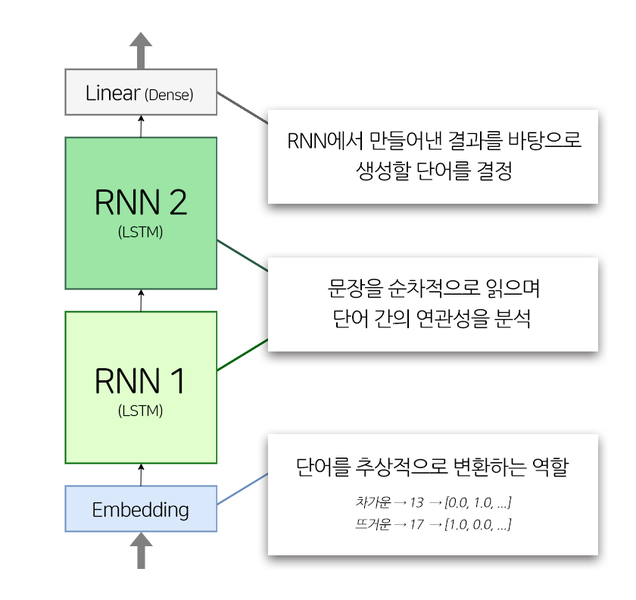

In [167]:
# 케라스 사용

class TextGenerator(tf.keras.Model):

    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        # 임베딩 레이어를 통해 tokenizer 텐서의 인덱스를 워드 벡터로 변환
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

print('Done!')

Done!


🥕 모델 생성이 완료되었습니다. loss 값이 부족하다면 임베딩이나 히든 사이즈 파라미터를 수정해주면 됩니다.

한 번 테스트 해볼까요?

In [168]:
# take 1
for src_sample, tgt_sample in dataset.take(1): break

model(src_sample)

<tf.Tensor: shape=(256, 16, 12001), dtype=float32, numpy=
array([[[-2.06716388e-04,  1.35010428e-04, -1.93828426e-04, ...,
         -2.10199330e-04, -2.20483111e-04, -2.19921058e-04],
        [-4.47649480e-04,  2.38746477e-04, -1.93273911e-04, ...,
         -2.09318241e-04, -1.59507195e-04, -2.82249210e-04],
        [-6.73800067e-04,  4.56040842e-04, -7.93112195e-05, ...,
         -2.95363629e-04, -1.54218622e-04, -4.70618746e-04],
        ...,
        [-4.36233269e-04,  8.95099074e-04, -1.23204221e-03, ...,
         -1.40273117e-03, -2.36717402e-03,  1.29180006e-03],
        [-3.45173408e-04,  1.31961808e-03, -1.53164170e-03, ...,
         -1.66025280e-03, -2.57976726e-03,  1.09381368e-03],
        [-2.56531755e-04,  1.71653763e-03, -1.79673883e-03, ...,
         -1.93475268e-03, -2.74155429e-03,  8.97774880e-04]],

       [[-2.06716388e-04,  1.35010428e-04, -1.93828426e-04, ...,
         -2.10199330e-04, -2.20483111e-04, -2.19921058e-04],
        [-2.25768410e-04,  2.14955217e-04, -9

🥕 워드 벡터를 갖고 있는 src_sample이 생성되었습니다. shape는 (256, 16, 12001)입니다.

배치 사이즈가 256이고 인풋 시퀀스 길이가 16에 Dense값은 단어사전 개수인 12001이네요.

조금 더 자세히 살펴보겠습니다.

In [169]:
model.summary()

Model: "text_generator_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     multiple                  3072256   
                                                                 
 lstm_14 (LSTM)              multiple                  5246976   
                                                                 
 lstm_15 (LSTM)              multiple                  8392704   
                                                                 
 dense_7 (Dense)             multiple                  12301025  
                                                                 
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


🥕 output의 크기는 알 수 없지만, 대략적인 모델의 파라미터 사이즈는 약 29M입니다.

한 번 학습을 시켜봅시다.

> **Ref.**
>
>- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
>
>- https://www.tensorflow.org/api_docs/python/tf/keras/losses

In [170]:
# 모델 학습
# 과연 얼마나 걸릴까요?
# 현재 환경은 구글 코랩, GPU 가속 모드입니다.

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)

print('Done!')

Done!


In [171]:
# history 변수에 담아서 추후 시각화를 해봅니다.

history = model.fit(enc_train,
                    dec_train,
                    epochs=10,
                    validation_data=(enc_val, dec_val),
                    verbose=1)

Epoch 1/10
4440/4440 [==============================] - 128s 28ms/step - loss: 2.6030 - val_loss: 2.3852
Epoch 2/10
4440/4440 [==============================] - 124s 28ms/step - loss: 2.2402 - val_loss: 2.2149
Epoch 3/10
4440/4440 [==============================] - 125s 28ms/step - loss: 2.0103 - val_loss: 2.1161
Epoch 4/10
4440/4440 [==============================] - 124s 28ms/step - loss: 1.8028 - val_loss: 2.0594
Epoch 5/10
4440/4440 [==============================] - 125s 28ms/step - loss: 1.6220 - val_loss: 2.0281
Epoch 6/10
4440/4440 [==============================] - 125s 28ms/step - loss: 1.4672 - val_loss: 2.0169
Epoch 7/10
4440/4440 [==============================] - 124s 28ms/step - loss: 1.3362 - val_loss: 2.0117
Epoch 8/10
4440/4440 [==============================] - 125s 28ms/step - loss: 1.2279 - val_loss: 2.0223
Epoch 9/10
4440/4440 [==============================] - 125s 28ms/step - loss: 1.1376 - val_loss: 2.0453
Epoch 10/10
4440/4440 [==============================] 

🥕 오래 걸렸지만, 훈련이 잘 끝났습니다!

한 번 테스트를 해보도록 하겠습니다.

---

## **04. 모델 평가**

In [172]:
# 평가를 위한 인풋 변환 함수 생성

def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):

    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]


    # 단어 하나씩 예측해 문장을 생성
    #    1. 입력받은 문장의 텐서를 입력
    #    2. 예측된 값 중 가장 높은 확률인 word index를 추출
    #    3. 2에서 예측된 word index를 문장 뒤에 붙임
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성 종료
    

    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    
    # tokenizer를 이용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [173]:
# i love 라는 구를 주면 뒷부분을 출력

generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love the way you lie now i know we had a lot more <end> '

🥕 주어진 문장의 뒷부분을 잘 예측하고 있네요.

흠, 한번 다른 문장을 몇 개 줘 볼까요?

> **Ref.**
>
> 가사가 아름다운 팝송 3pick | https://blog.naver.com/hacademia/221933788831

In [174]:
# 여러 가사를 시도

input_src = "i heard"
print(generate_text(model, tokenizer, init_sentence="<start> " + input_src, max_len=20))

<start> i heard you fucked your girl, is it true? <end> 


🥕 어.... 음...

이래서 애들 앞에서 고운 말을 써야 하는 거 같습니다. 😅

In [175]:
input_src = "you said"
print(generate_text(model, tokenizer, init_sentence="<start> " + input_src, max_len=20))

<start> you said you was king <end> 


🥕 문법이 틀린 부분이 조금씩 보이지만 아직까지 어떤 위치에 어떤 내용이 들어가야 하는지는 잘 아는 것 같습니다.

그렇다면 문장 부호를 섞어주면 어떨까요?

In [176]:
input_src = "when i was a kid,"
print(generate_text(model, tokenizer, init_sentence="<start> " + input_src, max_len=20))

<start> when i was a kid, s my heart <end> 


🥕 문제가 생기기 시작하네요. 다른 방법도 시도해 보겠습니다.

In [182]:
input_src = "my mother and i"
print(generate_text(model, tokenizer, init_sentence="<start> " + input_src, max_len=20))

input_src = "it s mine,"
print(generate_text(model, tokenizer, init_sentence="<start> " + input_src, max_len=20))

<start> my mother and i have never strength <end> 
<start> it s mine, i m here with you <end> 


🥕 loss값은 낮게 나왔지만 사람이 보기에 문장을 출력하는 성능이 썩 훌륭하진 않은 것 같네요.

말이 되는 문장을 아예 못 만드는 것은 아니지만... 학습하는 데이터가 얼마나 중요한지를 보여주는 요소였습니다.

---

# **회고**

> 머신러닝이든 딥러닝이든 학습 데이터가 중요하다고들 많이 하죠.
>
> 그런데 무엇이 어떻게 중요한지는 잘 언급하지 않는 경우가 많은데, 이번 프로젝트를 포함해 여러 익스 노드들을 하면서 '데이터가 중요하다'는 게 무슨 말인지 체감을 많이 하고 있습니다.
>
> 위에서 'i heard'를 넣었을 때 나오는 문구가 도대체 어쩌다 나왔을까 하고 알아보니, 학습 데이터로 쓰인 ***r-kelly가 소아성애자*** 였다고 하더라고요?
>
> 물론 컴퓨터에게 감정이나 악의가 있는 건 아니지만, 내부 프로세스를 잘 모르는 사람이 딥러닝 모델이 뱉어낸 말만 보고 감정이 상할 가능성은 충분하게 느껴졌습니다.
>
> 예전에 LG U+에서 아이들용 에듀콘텐츠 광고를 한 적이 있습니다.
>
> https://youtu.be/Zdhm277s0Ig
>
> 이건데, 좋은 콘텐츠를 학습한 AI 아이와 그렇지 않은 AI 아이 간에 발화 내용이 엄청나게 차이가 많이 나서 이슈가 됐었습니다.
>
> 왜 그랬는지, 어떻게 그런 일이 벌어졌는지 이제 알겠네요.
>
> 좋은 학습용 한국어 데이터가 영어에 비해 아직 상당히 부족한 편이라고 하던데 앞으로 많이 늘었으면 좋겠습니다.

# **끝!**